# Hopfield Network

In [1]:
import scipy as sp
import numpy as np
import scipy.integrate
import math
import random
import matplotlib.pyplot as plt

class HopfieldNetwork():
    
    def __init__(self, M, N, input_noise_level = 0):
        self.M = M
        self.N = N
        self.input_noise_level = input_noise_level
    
    def memories_and_weights(self):
        """Randomly generate a set of memories (stored patterns)
           and set the weights accordingly using Hebb's rule."""
        
        patterns = np.where(np.random.uniform(size=(self.M, self.N)) > 0.5, 0, 1)

        # Set connectivity weights using Hebb's rule
        V = np.sum([np.outer(p-0.5, p-0.5) for p in patterns], axis=0)
        W = V*(1-np.identity(self.N)) # Remove diagonal elements
                             
        return W, patterns
    
    def trial_count(self):
        """Return number of trials to be done in for
           a given number of stored of patterns m."""
        return 1000*(self.M <= 10) + 100*(10 < self.M < 100) + 10*(100 <= self.M <= 1000)
    
    def one_iteration(self):

        number_trials = self.trial_count() # Smaller number of trials for larger M.
        # Needs to be modified for M > 1000
        
        cumulative_error_rate = 0
        incorrect_fraction = []
        
        for trial in range(number_trials):
                        
            (W, patterns) = self.memories_and_weights()

            for pattern_index, pattern in enumerate(patterns):
                """Initialize the state S of the system to be one of the stored patterns, but with 
                'input noise level' (probability that a bit will randomly flip. Can think of it as
                the stored pattern with a small perturbation"""
                
                S = (pattern + np.where(np.random.uniform(size=self.N) > self.input_noise_level, 0, 1)) % 2

                # Simulate one iteration to see whether system settles back to the stored pattern
                h = np.array([row.dot(S) for row in W])
                S_new = np.where(h > 0, 1, 0) # Conditional update of each bit

                # Fraction of neurons in the given pattern that were recalled correctly
                fraction_correct = 1/self.N * np.sum(pattern == S_new) 
                
                # Fraction of bits that were incorrectly recalled
                cumulative_error_rate += (1 - fraction_correct)
                incorrect_fraction.append(1 - fraction_correct)
                
        error_probability = np.mean(incorrect_fraction) #cumulative_error_rate/(self.M*number_trials)
        uncertainty = np.std(incorrect_fraction)
        
        return  (error_probability, uncertainty)

# Theoretical error probability vs. number of patterns stored

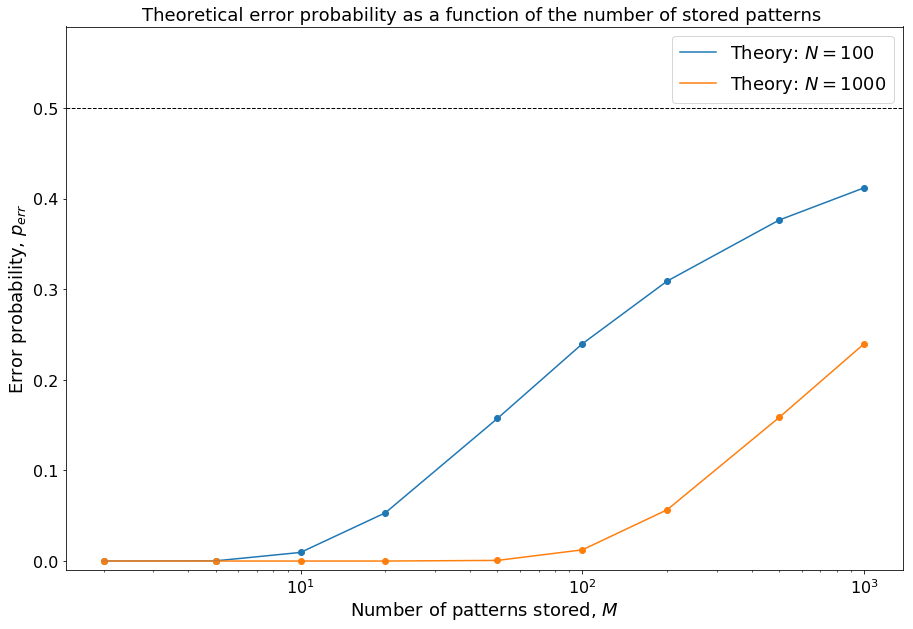

In [3]:
"""Array with the different values of M (number of patterns stored)"""
arrayM = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

N1 = 100
N2 = 1000

def rho_sigma(M, N):
    return (1/8*(N-1), np.sqrt(1/32*(M-1)*(N-1)))

comparison = []
for elem in arrayM:
    rho, sigma = rho_sigma(elem, N1)
    errProb = 1/2*sp.special.erfc(1/np.sqrt(2)*rho/sigma)
    comparison.append(errProb)
    
"""Theoretical error probabilities for each value of M, given N=10, 100, 1000, 10000"""
errProbs_theory100 = np.array([1/2*sp.special.erfc(1/2*np.sqrt((N1-1)/(elem-1))) for elem in arrayM])
errProbs_theory1000 = np.array([1/2*sp.special.erfc(1/2*np.sqrt((N2-1)/(elem-1))) for elem in arrayM])

plt.plot(arrayM, errProbs_theory100)
plt.plot(arrayM, errProbs_theory1000)
plt.axhline(0.5, 0, 10000, ls='--', lw=1.0, color='black')
plt.scatter(arrayM, errProbs_theory100)
plt.scatter(arrayM, errProbs_theory1000)
plt.title(r"Theoretical error probability as a function of the number of stored patterns ", fontsize=18)
plt.ylabel("Error probability, $p_{err}$", fontsize=18)
plt.ylim(-0.01, 0.59)
plt.yticks(fontsize=16)
plt.xlabel(r"Number of patterns stored, $M$", fontsize=18)
plt.xscale("log")
plt.xticks(fontsize=16)
plt.rcParams['figure.figsize'] = [15, 10]
plt.legend([r"Theory: $N=100$", r"Theory: $N=1000$"], fontsize=18)

In [4]:
means = []
errors = []
for elem in arrayM:
    hn = HopfieldNetwork(elem, 100)
    mean, error = hn.one_iteration()
    means.append(mean)
    errors.append(error)

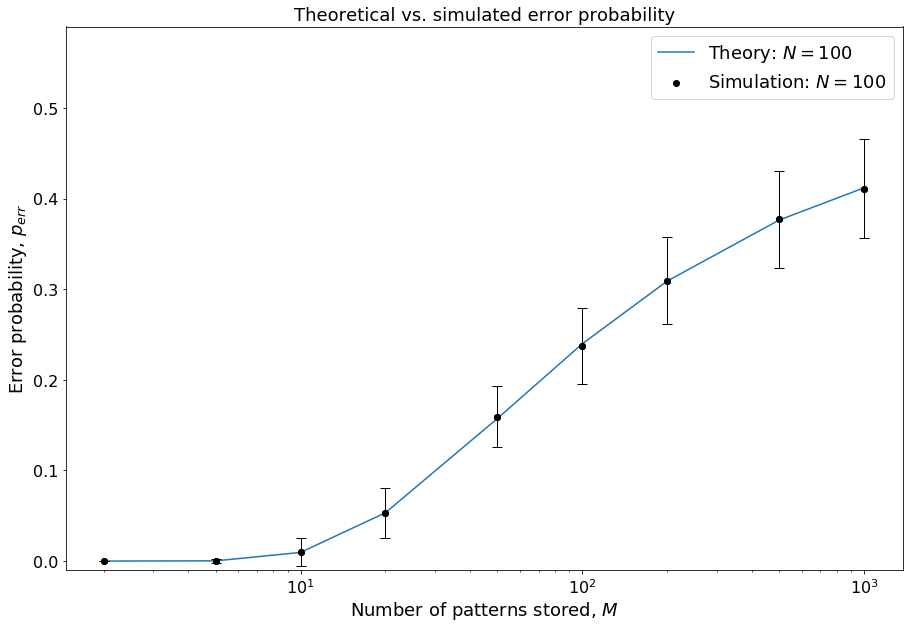

In [5]:
plt.plot(arrayM, errProbs_theory100, lw=1.5)
plt.scatter(arrayM, means, color='k')
plt.errorbar(arrayM, means, yerr=errors, capsize=5, color='k', lw=1.0, fmt='o')
plt.title("Theoretical vs. simulated error probability", fontsize=18)
plt.ylabel("Error probability, $p_{err}$", fontsize=18)
plt.ylim(-0.01, 0.59)
plt.yticks(fontsize=16)
plt.xlabel(r"Number of patterns stored, $M$", fontsize=18)
plt.xscale("log")
plt.xticks(fontsize=16)
plt.rcParams['figure.figsize'] = [15, 10]
plt.legend([r"Theory: $N=100$", r"Simulation: $N=100$"], fontsize=18)

In [40]:
input_signal_noise = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1.0])

y = []
dy = []

for p in input_signal_noise:
    #print(f"Input noise level: {p}")
    means = []
    errors = []
    for elem in arrayM:
        #print(f"M={elem}")
        hn = HopfieldNetwork(elem, 100, p)
        mean, error = hn.one_iteration()
        means.append(mean)
        errors.append(error)
    y.append(means)
    dy.append(errors)

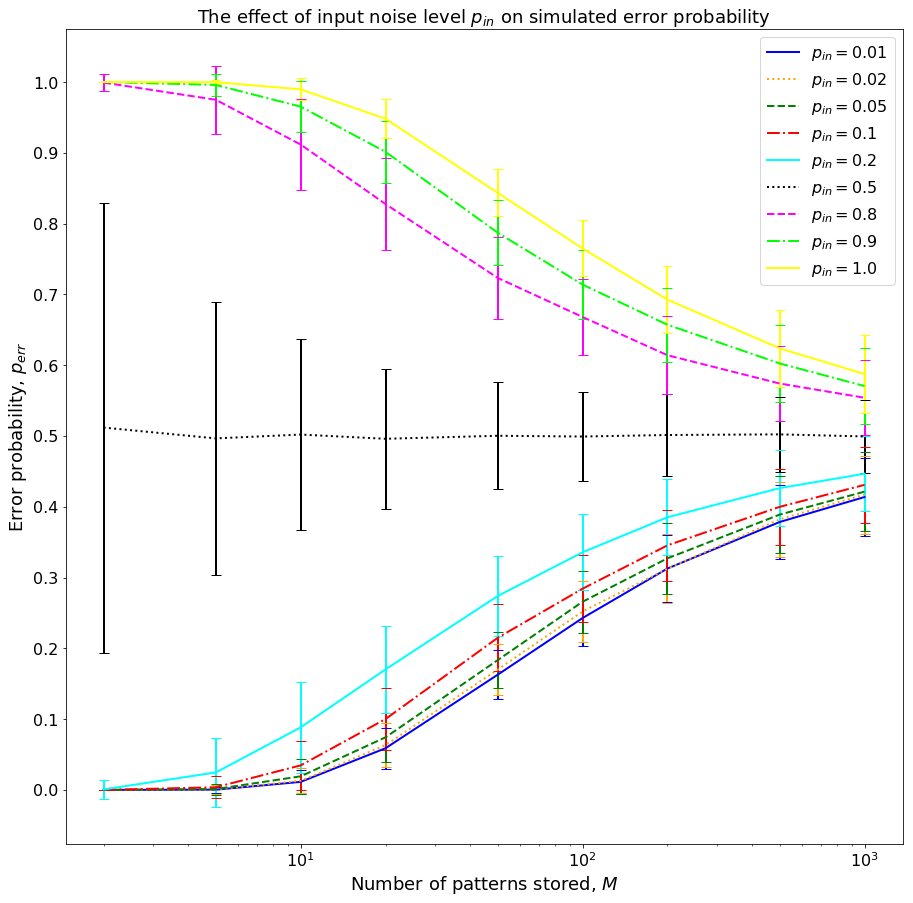

In [44]:
linestyles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot", "solid"]
colours = ["blue", "orange", "green", "red", "cyan", "black", "magenta", "lime", "yellow"]

fig, ax = plt.subplots()
for i, curve in enumerate(y):
    plt.errorbar(arrayM, curve, yerr=dy[i], capsize=5,
                 label=r"$p_{in}=$"+f"{input_signal_noise[i]}", 
                 ls=f"{linestyles[i]}",
                 color=f"{colours[i]}",
                 lw=2.0)
ax.set_title(r"The effect of input noise level $p_{in}$ on simulated error probability", fontsize=18)
ax.set_xscale("log")
ax.set_xlabel(r"Number of patterns stored, $M$", fontsize=18)
ax.set_ylabel("Error probability, $p_{err}$", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]    # Remove the errorbars from the legend
plt.legend(handles, labels, loc='upper right', numpoints=1, fontsize=16) # Use handles and labels in the legend
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=16)
plt.xticks(fontsize=16)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()